In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import XLNetModel, XLNetConfig, XLNetTokenizer
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig


from transformers import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import textwrap
import math
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()

In [2]:
df_train = pd.read_csv('/home/m_nsu/ICLR/Datasets/IMDB/train.csv')
df_val = pd.read_csv('/home/m_nsu/ICLR/Datasets/IMDB/val.csv')
df_test = pd.read_csv('/home/m_nsu/ICLR/Datasets/IMDB/test.csv')

In [3]:
df_senti = pd.read_excel('/home/m_nsu/ICLR/Datasets/GoEmotion/sentiwords.xlsx')
conditions = [
    (df_senti['PosScore'] > df_senti['NegScore']),
    (df_senti['PosScore'] < df_senti['NegScore']),
    (df_senti['PosScore'] == df_senti['NegScore'])
    ]

values = ['Positive','Negative','Neutral']

df_senti = df_senti[['PosScore','NegScore','Word','Definition']]
df_senti['Sentiment'] = np.select(conditions, values)
df_senti = df_senti.dropna(axis=0)
df_senti.drop(columns=['PosScore', 'NegScore'], inplace=True)
df_senti = df_senti[['Word', 'Sentiment', 'Definition']]

In [4]:
df_train.dropna(inplace=True)

In [5]:
df_train.head()

,Unnamed: 0,review,sentiment
0,48539,This was a very funny movie not Oscarworthy bu...,0
1,26308,I know this film has had a fairly rough ride f...,0
2,14603,Being stuck in bed with the flu and feeling to...,1
3,45794,This isnt exactly a great film but I admire th...,0
4,21688,It is difficult to rate a writerdirectors firs...,1


In [6]:
MAX_LEN = 200
RANDOM_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
PRE_TRAINED_MODEL_NAME = 'roberta-large'
config = RobertaConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
clear_output()
print(device)

cuda


In [8]:
pre_trained_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
clear_output()

In [9]:
def get_cls(sent):
  encoded_review = tokenizer.encode_plus(
  sent,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation = True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  pre_trained_model.eval()
  with torch.no_grad():
    output = pre_trained_model(input_ids, attention_mask)
    return torch.mean(output[0], dim=1)[0] #Output Avg pooled vector embedding of last layer

In [10]:
neg_words = ['ambiguous','angry','annoying','appalling','awful','barbaric','bizarre','blasphemous','brainless','chaotic','contradictory','controversy','cringe','cruel',
             'degrading','disturbed','failed','fake','gimmick','hateful','hideous','inadequate','inappropriate','incoherent','loopholes','meaningless','obscure','offensive',
             'pathetic','weird']
            
pos_words = ['acclaimed','accurate','adventurous','astonishing','authentic','beautiful','calming','catchy','charismatic','cheerish','coherent','constructrive','cool',
             'cute','daring','eloquent','enthusiastic','romantic','flawless','humorous','inspirational','love','modern','motivated','obsession','phenomenal','relistic',
             'refreshing','vibrant','wholesome']


new_pos_words = ['captivating','enjoy','outstanding','thoughtful','fun', 'pleasant', 'warm', 'enticing', 'realistic','friendly']
new_neg_words = ['biased','horrible','bored','disappointed','frustrate','hostile','ridiculous','malign','rude','unpleasant']

In [14]:
positive_word_meaning_sentences = [
'to praise or welcome somebody/something publicly', #acclaimed(verb)
'correct and true in every detail', #accurate(adjective)
'including new and interesting things, methods and ideas', #adventurous(adjective)
'very surprising; difficult to believe',#astonishing (adjective)
'known to be real and what somebody claims it is and not a copy',#authentic(adjective)
'having beauty; giving pleasure to the senses or to the mind', #beautiful(adjective)
'to make somebody/something become quiet and more relaxed, especially after strong emotion or excitement',#calming(verb)
'pleasant and easily remembered',#catchy(adjective)
'the powerful personal quality that some people have to attract and impress other people',#charisma(noun)
'(of a person or their behaviour) happy and cheerful',#cheery(adjective)
'(of ideas, thoughts, arguments, etc.) logical and well organized; easy to understand and clear',#coherent(adjective)
'having a useful and helpful effect rather than being negative or with no purpose',#constructive(adjective)
'used to show that you admire or approve of somebody/something because they are/it is fashionable, attractive and often different',#cool(adjective)
'pretty and attractive',#cute(adjective)
'brave; willing to do dangerous or unusual things; involving danger or taking risks',#daring(adjective)
'able to use language and express your opinions well, especially when you are speaking in public',#eloquent(adjective)
'feeling or showing a lot of excitement and interest about somebody/something',#enthusiastic(adjective)
'without flaws and therefore perfect',#flawless(adjective)
'funny; showing a sense of humour',#humorous(adjective)
'providing exciting new ideas; making somebody want to create something, especially in art, literature or music',#inspirational(adjective)
]

new_positive_word_meaning_sentences = [
'taking all your attention; very attractive and interesting',#captivating(adjective)
'to get pleasure from something',#enjoy(verb)
'extremely good; excellent',#outstanding(adjective)
'showing that you think about and care for other people',#thoughtful(adjective)
'the feeling of enjoying yourself; activities that you enjoy',#fun(noun)
'affording pleasure; being in harmony with your taste or likings', 
'get warm or warmer', 
'provoke someone to do something through (often false or exaggerated', 
'aware or expressing awareness of things as they really are', 
'kind and pleasant',
'a very strong feeling of liking and caring for somebody/something, especially a member of your family or a friend',#love(noun)
'of the present time or recent times',#modern(adjective)
'wanting to do something, especially something that involves hard work and effort',#motivated(adjective)
'a person or thing that somebody thinks about too much',#obsession(noun)
'very great or impressive',#phenomenal(adjective)
'accepting in a sensible way what it is actually possible to do or achieve in a particular situation',#realistic(adjective)
'pleasantly new or different',#refreshing(adjective)
'connected with or about love or a sexual relationship',#romantic(adjective)
'full of life and energy',#vibrant(adjective)
'morally good; having a good moral influence'#wholesome(adjective)
]


negative_word_meaning_sentences = [
'that can be understood in more than one way; having different meanings', #ambiguous(adjective)
'having strong feelings about something that you dislike very much or about an unfair situation',#angry(adjective)
'making somebody feel slightly angry',#annoying(adjective)
'extremely bad, especially from a moral point of view',#appalling(adjective)
'very bad or unpleasant',#awful(adjective)
'cruel and violent and not as expected from people who are educated and respect each other',#barbaric(adjective)
'very strange or unusual',#bizarre(adjective)
'(of behaviour or language) showing a lack of respect for God or religion',#blasphemous(adjective)
'stupid; not able to think or talk in an intelligent way',#brainless(adjective)
'without any order; in a completely confused state',#chaotic(adjective)
'containing or showing a lack of agreement between statements, facts, opinions or actions',#contradictory(adjective)
'public discussion and argument about something that many people strongly disagree about, think is bad, or are shocked by',#controversy(noun)
'to feel very embarrassed and uncomfortable about something',#cringe(verb)
'having a desire to cause physical or mental pain and make somebody suffer',#cruel(adjective)
'treating somebody as if they have no value, so that they lose their self-respect and the respect of other people',#degrading(adjective)
'mentally ill, especially because of very unhappy or unpleasant experiences',#disturbed(adjective)
'not successful', #failed(adjective)
'not what somebody claims it is; appearing to be something it is not',#fake(adjective)
'an unusual trick or unnecessary device that is intended to attract attention or to persuade people to buy something',#gimmick(noun)
'very unkind or unpleasant',#hateful(adjective)
]

new_negative_word_meaning_sentences = [
'tending to show favour towards or against one group of people or one opinion for personal reasons; making unfair judgements',#biased(adjective)
'very bad or unpleasant; used to describe something that you do not like',#horrible(adjective)
'feeling tired and impatient because you have lost interest in somebody/something or because you have nothing to do',#bored(adjective)
'upset because something you hoped for has not happened or been as good, successful, etc. as you expected',#disappointed(adjective)
'to make somebody feel annoyed or impatient because they cannot do or achieve what they want',#frustrate(verb),
'showing or feeling opposition or dislike; unfriendly',
'inspiring scornful pity', 
'speak unfavorably about', 
'socially incorrect in behavior', 
'offensive or disagreeable; causing discomfort or unhappiness',
'very ugly or unpleasant',#hideous(adjective)
'not enough; not good enough',#inadequate(adjective)
'not suitable or appropriate in a particular situation',#inappropriate(adjective)
'unable to express yourself clearly, often because of emotion',#incoherent(adjective)
'a mistake in the way a law, contract, etc. has been written that enables people to legally avoid doing something that the law, contract, etc. had intended them to do',#loophole(noun)
'without any purpose or reason and therefore not worth doing or having',#meaningless(adjective)
'difficult to understand',#obscure(adjective)
'rude in a way that causes somebody to feel upset or annoyed because it shows a lack of respect',#offensive(adjective)
'making you feel sad',#pathetic
'very strange or unusual and difficult to explain',#weird(adjective)
]

In [15]:
print(len(new_positive_word_meaning_sentences))
print(len(new_negative_word_meaning_sentences))

20
20


In [16]:
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)


for i in positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)



p_emb = p_emb[1:]
n_emb = n_emb[1:]

In [17]:
print(p_emb.shape)
print(n_emb.shape)

torch.Size([20, 1024])
torch.Size([20, 1024])


In [18]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]


    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation = True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long),

    }

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
  )

In [20]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [22]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,config=config)
    self.FC = nn.Linear(config.hidden_size,config.hidden_size, bias=False)

  def CosineNorm(self, c, b, n_words):
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-8)
    simi = torch.tensor([[1.]*n_words]).to(device)
    for i in c:
      temp = cos(i,b).to(device)
      temp = torch.unsqueeze(temp,0)
      simi = torch.cat((simi,temp), dim=0)

    return simi[1:]

  def binary_output(self,positive, negative):
    positive = torch.max(positive,1).values
    negative = torch.max(negative,1).values

    p_temp = torch.unsqueeze(positive,0)
    n_temp = torch.unsqueeze(negative,0)


    res = torch.cat((p_temp,n_temp), dim=0)

    return torch.t(res)

  def forward(self, input_ids, attention_mask, return_scores=False):
    with torch.no_grad():
      pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict = False
      )
    pooled_output = torch.mean(pooled_output[0], dim=1) # Taking Averge pooled last layer embedding

    x_sent = self.FC(pooled_output)

    Ept = self.FC(p_emb)
    Ent = self.FC(n_emb)

    positive = F.relu(self.CosineNorm(x_sent, Ept, p_emb.size()[0]))
    negative = F.relu(self.CosineNorm(x_sent, Ent, n_emb.size()[0]))

    binary_out = self.binary_output(positive,negative)
    if(return_scores==True):
      return (positive,negative) , binary_out
    return binary_out

In [23]:
model = Classifier()
model = model.to(device)
clear_output()

In [24]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [25]:
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [26]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
sentiments = data['sentiments'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 200])
torch.Size([32, 200])


In [27]:
#del test
torch.cuda.empty_cache()

In [28]:
(positive,negative),outs = model(input_ids, attention_mask,return_scores=True)

In [29]:
outs

tensor([[0.9874, 0.9871],
        [0.9843, 0.9848],
        [0.9839, 0.9840],
        [0.9831, 0.9835],
        [0.9866, 0.9864],
        [0.9842, 0.9847],
        [0.9826, 0.9827],
        [0.9767, 0.9762],
        [0.9822, 0.9819],
        [0.9857, 0.9857],
        [0.9845, 0.9844],
        [0.9847, 0.9847],
        [0.9820, 0.9820],
        [0.9816, 0.9816],
        [0.9870, 0.9868],
        [0.9804, 0.9803],
        [0.9835, 0.9839],
        [0.9890, 0.9895],
        [0.9857, 0.9855],
        [0.9856, 0.9854],
        [0.9825, 0.9827],
        [0.9864, 0.9865],
        [0.9832, 0.9829],
        [0.9809, 0.9810],
        [0.9891, 0.9890],
        [0.9861, 0.9863],
        [0.9871, 0.9869],
        [0.9882, 0.9881],
        [0.9827, 0.9830],
        [0.9837, 0.9836],
        [0.9899, 0.9909],
        [0.9849, 0.9841]], device='cuda:0', grad_fn=<TBackward0>)

In [30]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=0.001)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=math.floor((1./5)*total_steps),
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).to(device)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())


    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples, on_new=False):
  model = model.eval()

  losses = []
  f1s = []

  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      ).to(device)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

      f1s.append(f1_score(sentiments.cpu(), preds.cpu(), average='macro'))

  return correct_predictions.double() / n_examples, np.mean(losses), np.mean(f1s)

In [33]:
def batch_calc_score_sum(positive, negative, sentiments):
  p_filter = sentiments ^ torch.ones(sentiments.size()[0], dtype=torch.int8).to(device) # Positive ( sentiment xor [1,1,...])
  n_filter = sentiments # Negative

  pos_score_pos_sent = positive[p_filter.nonzero(), :]
  pos_score_neg_sent = positive[n_filter.nonzero(), :]

  neg_score_pos_sent = negative[p_filter.nonzero(), :]
  neg_score_neg_sent = negative[n_filter.nonzero(), :]

  pp_count = pos_score_pos_sent.size()[0]
  pn_count = pos_score_neg_sent.size()[0]
  pp_sum = torch.sum(pos_score_pos_sent,dim=0)
  pn_sum = torch.sum(pos_score_neg_sent,dim=0)


#  np_count = neg_score_pos_sent.size()[0] # same as pn_count
#  nn_count = neg_score_neg_sent.size()[0] # same as pn_count
  np_sum = torch.sum(neg_score_pos_sent,dim=0)
  nn_sum = torch.sum(neg_score_neg_sent,dim=0)

  return pp_sum,pn_sum,np_sum,nn_sum, pp_count, pn_count

def eval_scores_average(model, data_loader, device):
  model = model.eval()


  pp_sum_agg = torch.zeros(1,p_emb.size()[0]).to(device)
  pn_sum_agg = torch.zeros(1,p_emb.size()[0]).to(device)

  np_sum_agg = torch.zeros(1,n_emb.size()[0]).to(device)
  nn_sum_agg = torch.zeros(1,n_emb.size()[0]).to(device)

  pp_count_agg, pn_count_agg = 0,0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      (positive,negative),_= model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_scores=True
      )
      positive.to(device)
      negative.to(device)


      pp_sum,pn_sum,np_sum,nn_sum, pp_count, pn_count = batch_calc_score_sum(positive,negative,sentiments)

      pp_sum_agg += pp_sum
      pn_sum_agg += pn_sum

      np_sum_agg += np_sum
      nn_sum_agg += nn_sum

      pp_count_agg += pp_count
      pn_count_agg += pn_count



  return pp_sum_agg/pp_count_agg, pn_sum_agg/pn_count_agg, np_sum_agg/pp_count_agg, nn_sum_agg/pn_count_agg

In [34]:
def box_plot(pp,pn,np,nn):
  pp = pp.tolist()[0]
  pn = pn.tolist()[0]
  np = np.tolist()[0]
  nn = nn.tolist()[0]
  # Create a box plot with beeswarm using seaborn
  sns.set(style="whitegrid")  # Set the style of the plot
  plt.figure(figsize=(8, 6))  # Set the figure size
  ax = sns.boxplot(data=[pp,pn,np,nn], orient="v", palette="Set2")  # Create the box plot
  ax = sns.swarmplot(data=[pp,pn,np,nn], orient="v", color="0.2")  # Add the swarm plot

  # Set labels for the axes
  ax.set_xlabel('Categories')
  ax.set_xticklabels(['pp','pn','np','nn'])
  ax.set_ylabel('Scores(µ)')

  # Set a title for the plot
  #plt.title()

  # Show the plot
  plt.show()

In [35]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(4):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss, val_f1 = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'roberta_best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.4778975872755051 accuracy 0.846875
Val   loss 0.42859320940485424 accuracy 0.8846

Epoch 2/8
----------
Train loss 0.4241860244750977 accuracy 0.888625
Val   loss 0.42198177185028224 accuracy 0.8882

Epoch 3/8
----------
Train loss 0.415394753909111 accuracy 0.8954500000000001
Val   loss 0.42254803818502246 accuracy 0.8872

Epoch 4/8
----------
Train loss 0.4119105999469757 accuracy 0.898475
Val   loss 0.41206184731926887 accuracy 0.9

CPU times: user 1h 54min 51s, sys: 8.02 s, total: 1h 54min 59s
Wall time: 1h 55min 3s


In [36]:
train_a = [i.item() for i in train_a]
train_l = [i.item() for i in train_l]
val_a = [i.item() for i in val_a]
val_l = [i.item() for i in val_l]

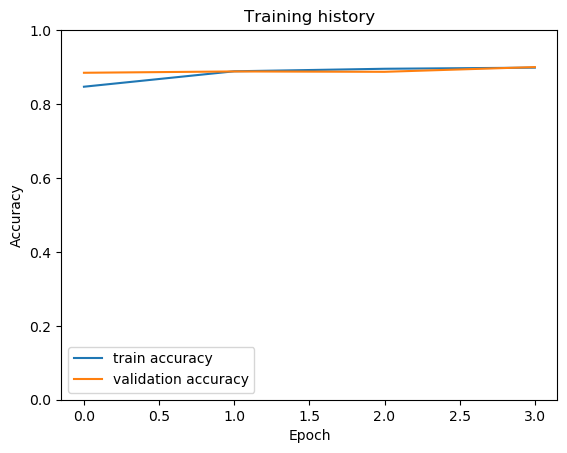

In [37]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Accuracy of Pos/Neg on Test Set

In [38]:
import numpy as np
test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.9002
F1-Macro:  0.8963633216198105


Scores Average of PP - Poisitve Scores on Positive Sentences
                  PN - Poisitve Scores on Negative Sentences
                  NP - Negative Scores on Positive Sentences
                  NN - Negative Scores on Negative Sentences

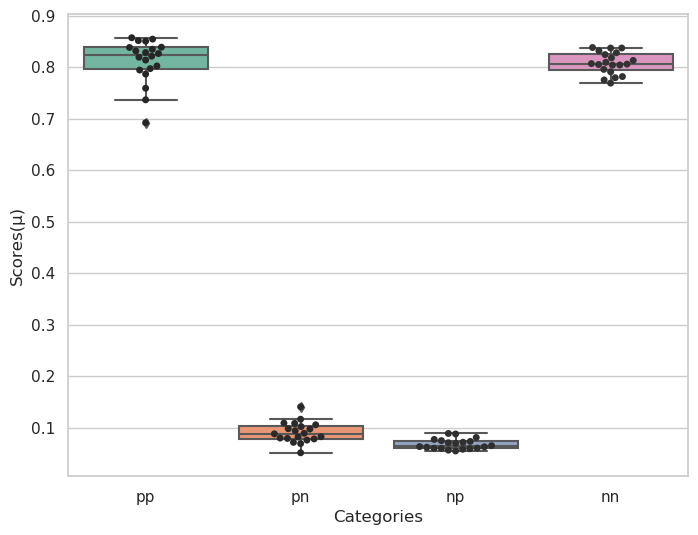

In [39]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

Accuracy of Emotions on Test Set

In [40]:
def get_predictions(model, data_loader):
  model = model.eval()

  review = []
  predictions = []

  prediction_probs = []
  real_values = []

  pos_scores = []
  neg_scores = []


  with torch.no_grad():
    for d in data_loader:

      reviews = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)


      scores,outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_scores=True,
      )
      _, preds = torch.max(outputs, dim=1)


      probs = F.softmax(outputs, dim=1)

      review.extend(reviews)
      predictions.extend(preds)

      prediction_probs.extend(probs)
      real_values.extend(sentiments)

      pos_scores.extend(scores[0])
      neg_scores.extend(scores[1])


  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
    
  pos_scores = torch.stack(pos_scores).cpu()
  neg_scores = torch.stack(neg_scores).cpu()
  return review, predictions, prediction_probs, real_values, pos_scores, neg_scores

In [41]:
y_review_texts, y_pred , y_pred_probs, y_test, pos_scores, neg_scores = get_predictions(
  model,
  test_data_loader
)

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
class_names = ['negative', 'positive']

Pos/Neg Classification Report

In [43]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.92      0.90      2511
    positive       0.92      0.88      0.90      2489

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



Reverse Native Injection Accuracy

In [44]:
import numpy as np
p_emb, n_emb = n_emb, p_emb


test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.0998
F1-Macro:  0.09741574339051826


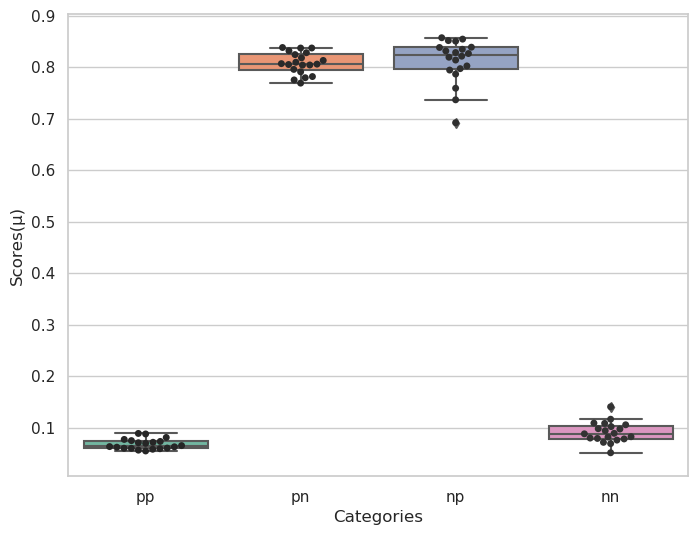

In [45]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

Foreign Injection Accuracy

In [46]:
import numpy as np



p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in new_positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in new_negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.8748
F1-Macro:  0.8700875816356158


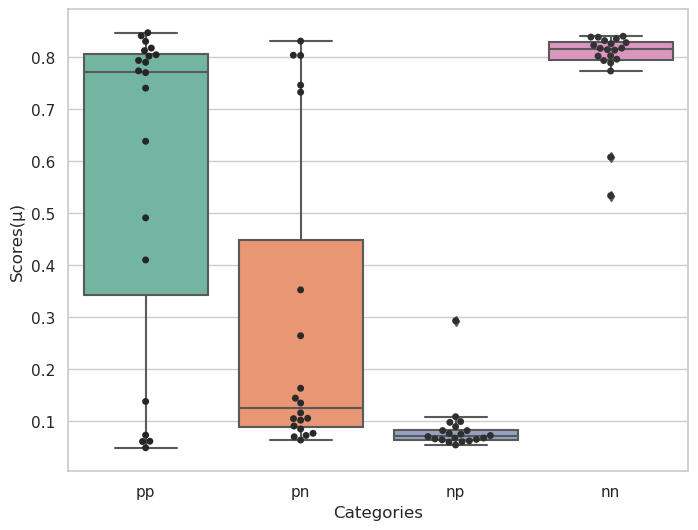

In [47]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

In [48]:
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")


def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")
clear_output()

In [49]:
from IPython.display import clear_output

In [50]:
new_positive_word_meaning_sentences = ['an acknowledgement or a public welcome',
 'true to the point',
 'including new and interesting things, methods and ideas',
 "it's surprising",
 'known to be real and what somebody claims it is and not a copy',
 'beauty delights the senses or the mind',
 "to make someone quiet and more relaxed especially when there's intense emotion or excitement",
 'pleasant and easily remembered',
 'the personal power of a person to attract and impress other people',
 '(of a person or their behaviour) happy and cheerful',
 '(of ideas, thoughts, arguments, etc.) logical and well organized; easy to understand and clear',
 'having a useful and helpful effect rather than being negative or with no purpose',
 'used to show that you admire or approve of somebody/something because they are/it is fashionable, attractive and often different',
 'attractive and pretty',
 'brave enough to do something dangerous or unusual involving danger or taking risks',
 'allow yourself to use language and express your views well especially when speaking in public',
 'feeling excitement or showing an interest about someone  something',
 'without flaws and therefore perfect',
 'funny with a sense of humor',
 'providing exciting new ideas; making somebody want to create something, especially in art, literature or music' 
 ]


new_negative_word_meaning_sentences = ['that can be understood in more than one way; having different meanings',
 'having strong feelings about something you really dislike or an unfair situation',
 'making somebody feel slightly angry',
 'extremely bad, especially from a moral point of view',
 'very bad or uncomfortable',
 'cruel and violent and not what one wants from people who suss out education and respect each other',
 'very strange or unusual',
 '(of behaviour or language) showing a lack of respect for God or religion',
 'stupid; not able to think or talk in an intelligent way',
 'without any order; in a completely confused state',
 'containing or showing a lack of agreement between statements, facts, opinions or actions',
 'public discussion and argument about something that many people strongly disagree about, think is bad, or are shocked by',
 'to feel very embarrassed about something',
 'a desire to cause psychological or physical pain',
 "treating someone as if they don't have any value so that they lose their self-respect and respect for other people",
 'mentally ill particularly because of very unpleasant or extremely unhappy experiences',
 'not doing well',
 'not what somebody claims it is; appearing to be something it is not',
 "a strange trick or unnecessary device that's meant to appeal to people or to get them to buy something",
 'very unfriendly or unpleasant'
 ]


Paraphrased Native Injection Accuracy

In [51]:
import numpy as np
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in new_positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in new_negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)



print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.8884000000000001
F1-Macro:  0.8843396816543188


In [52]:
import random
random.seed(42)

inputNumbers = range(0,10000)
random_seeds = random.sample(inputNumbers, 300)

In [56]:
import numpy as np

In [ ]:
f1s = []
accuracy = []
p_word_list = []
n_word_list = []

In [73]:

print("Working", end=' ')
for i in range(186,300):
    #SELECT RANDOM WORDS FROM NEUTRAL SENTIWORD
    df_neutral = df_senti[df_senti['Sentiment']=='Neutral'].sample(n=20, random_state=random_seeds[i])
    neutral_words = list(df_neutral["Word"])

    #FETCH DEFINITIONS OF THOSE WORDS
    neutral_word_meaning_sentences = []
    for i in neutral_words:
        a = list(df_senti.loc[df_senti['Word'] == i, 'Definition'])[0]
        neutral_word_meaning_sentences.append(a)

    #MAKE EMBEDDING OF THESE DEFINITIONS
    neutral_p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
    neutral_n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)


    for i in neutral_word_meaning_sentences[0:10]:
      neutral_p_emb = torch.cat((neutral_p_emb,get_cls(i).unsqueeze(0)), dim=0)

    for i in neutral_word_meaning_sentences[10:20]:
      neutral_n_emb = torch.cat((neutral_n_emb,get_cls(i).unsqueeze(0)), dim=0)

    p_emb = neutral_p_emb[1:]
    n_emb = neutral_n_emb[1:]

    print('...', end=' ')

    p_samples = neutral_words[0:10]
    n_samples = neutral_words[10:20]

    #EVALUATE ON THESE WORDS
    test_acc,_, test_f1 = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test),
    )

    accuracy.append(test_acc.item())
    f1s.append(test_f1.item())
    p_word_list.append(p_samples)
    n_word_list.append(n_samples)


Working ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... 

In [75]:
import statistics

In [76]:
stdv = statistics.pstdev(f1s)
median = statistics.median(f1s)
#filters = [i>median+(2*stdv) for i in f1s]
filters = [i>.7 for i in f1s]
def filter_2std(target_list, filters):
    index = [i for i in range(len(filters)) if filters[i]]
    list_a_filtered = [target_list[i] for i in index]
    return list_a_filtered

p_words_spurious = filter_2std(p_word_list,filters)
n_words_spurious = filter_2std(n_word_list,filters)

#print(p_words_spurious)
#print(n_words_spurious)

Neutral Injection Accuracies

In [77]:
import numpy as np

In [78]:
(hist, bin_edges) = np.histogram(f1s,bins=15)

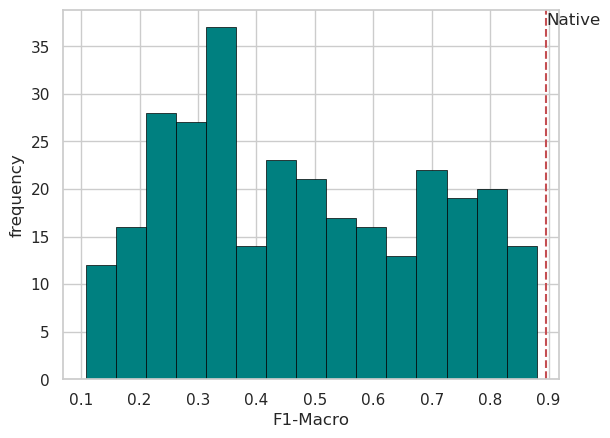

In [79]:
plt.hist(f1s, bins=15,facecolor = '#008080', edgecolor='#000000', linewidth=0.5)


vertical_line_position = 0.896  # Change this to the desired position
plt.axvline(x=vertical_line_position, color='r', linestyle='--', label='Vne')
plt.text(x=vertical_line_position,y=max(hist),s='Native',ha='left', va='bottom')

    
plt.xlabel("F1-Macro")
plt.ylabel("frequency")

#plt.title("bert-base")
plt.show()

In [80]:
'''
df_randomization_test = pd.DataFrame(list(zip(f1s, accuracy,p_word_list,n_word_list)),
               columns =['f1s', 'accuracy','p_word_list','n_word_list'])
df_randomization_test.to_csv('roberta_randomizationtest.csv')
'''

In [90]:
f1s.index(0.8736705409712142)

57

In [91]:
df_neutral = df_senti[df_senti['Sentiment']=='Neutral'].sample(n=20, random_state=random_seeds[11])
neutral_words = list(df_neutral["Word"])

#FETCH DEFINITIONS OF THOSE WORDS
neutral_word_meaning_sentences = []
for i in neutral_words:
    a = list(df_senti.loc[df_senti['Word'] == i, 'Definition'])[0]
    neutral_word_meaning_sentences.append(a)

In [92]:
import numpy as np
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in neutral_word_meaning_sentences[0:10]:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in neutral_word_meaning_sentences[10:20]:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.49400000000000005
F1-Macro:  0.48374411815421087


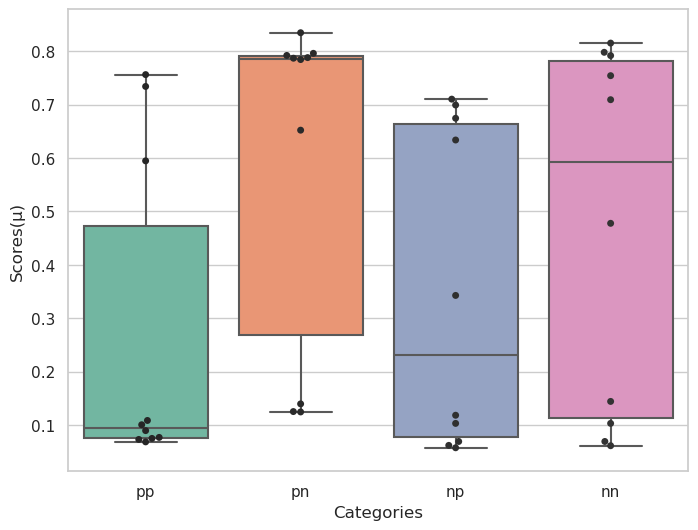

In [93]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

In [94]:
p_spurious_sentences = [list(df_senti[df_senti['Word'] == i]['Definition'])[0] for i in p_words_spurious[0]]
n_spurious_sentences = [list(df_senti[df_senti['Word'] == i]['Definition'])[0] for i in n_words_spurious[0]]

Accuracy:  0.8028000000000001
F1-Macro:  0.7962240928600959


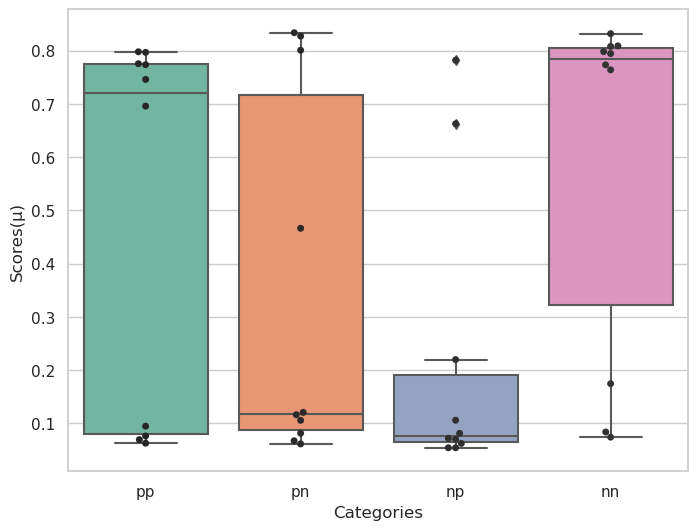

In [95]:
import numpy as np
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in p_spurious_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in n_spurious_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())


pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

In [96]:
n_words_spurious[0]

['radicalism',
 'tilting_board teetertotter teeterboard teeter-totter teeter seesaw dandle_board',
 'war-worn war-torn',
 'allegorize allegorise',
 'writ_of_election',
 'oven_broil broil',
 'slop_bowl slop_basin',
 'rank_and_file rank',
 'agama',
 'sacral_vertebra']

In [97]:
p_words_spurious[0]

['jupiter_optimus_maximus best_and_greatest',
 'double_cross double-crossing',
 'mccormick cyrus_mccormick cyrus_hall_mccormick',
 'sandwich_board',
 'noncombinative',
 'business_traveler',
 'pinus genus_pinus',
 'pilus',
 'extrovert extravert',
 'psidium_guineense brazilian_guava']

Using Bias categories to test if they are neutral or not

In [98]:
import os, sys

filenames = []

path = "/home/m_nsu/ICLR/Datasets/GoEmotion/bias_criterias"
dir = os.listdir( path )

for file in dir:
   if(file.endswith('.csv')):
    filenames.append(file)

In [99]:
import numpy as np
for filename in filenames:
    df_bias = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/bias_criterias/'+filename)

    p_spurious_sentences = list(df_bias['Definition'])

    p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
    n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

    for i in p_spurious_sentences:
      p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    for i in neutral_word_meaning_sentences[10:20]:
      n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    p_emb = p_emb[1:]
    n_emb = n_emb[1:]

    test_acc, _, test_f1 = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test)
    )

    positive_spurious = test_f1.item()

    n_spurious_sentences = list(df_bias['Definition'])
    p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
    n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

    for i in neutral_word_meaning_sentences[0:10]:
      p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    for i in n_spurious_sentences:
      n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    p_emb = p_emb[1:]
    n_emb = n_emb[1:]

    test_acc, _, test_f1 = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test)
    )

    negative_spurious = test_f1.item()

    if positive_spurious>=0.6:
      print(filename+' is Positively Spurious.')
    if negative_spurious>=0.6:
      print(filename+' is Negatively Spurious.')
    if(positive_spurious<0.6 and negative_spurious<0.6):
      print(filename+' is Neutral.')
    print('Positive Acc:',positive_spurious,'\n'+'Negative Acc:', negative_spurious)
    print("------------------------------------------------------------------------")

Advocate.csv is Positively Spurious.
Positive Acc: 0.8787039202197783 
Negative Acc: 0.11089385762947129
------------------------------------------------------------------------
Dialogue.csv is Positively Spurious.
Positive Acc: 0.8904984997746103 
Negative Acc: 0.10461615027262268
------------------------------------------------------------------------
Indian.csv is Positively Spurious.
Positive Acc: 0.8653068421848689 
Negative Acc: 0.14166424195629557
------------------------------------------------------------------------
Orientation.csv is Positively Spurious.
Positive Acc: 0.8193288886200251 
Negative Acc: 0.14971622041253732
------------------------------------------------------------------------
Colored.csv is Positively Spurious.
Positive Acc: 0.8759178690879418 
Negative Acc: 0.11315375629761636
------------------------------------------------------------------------
occupations1950_nonprofessional.csv is Positively Spurious.
Positive Acc: 0.7766066587348277 
Negative Acc: 0.